<a href="https://colab.research.google.com/github/ostrichkim/colab/blob/main/asignment_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy folder
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models /content/
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py /content/

'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models' -> '/content/models'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/resnet.py' -> '/content/models/resnet.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/dla_simple.py' -> '/content/models/dla_simple.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/MobileNetV2.py' -> '/content/models/MobileNetV2.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/__init__.py' -> '/content/models/__init__.py'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [ ]:
img_size=112
learning_rate = 0.01
epochs = 30
weight_decay = 5e-4
momentum = 0.9
batch_size = 32
num_workers = 2
num_classes = 20

In [ ]:
# # Normalize with mean and std
# from torchvision.io import read_image
# from torchvision import datasets

# # trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data',
# #                  transform=transforms.ToTensor())
# trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200',
#                  transform=transforms.ToTensor())
# testset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data',
#                  transform=transforms.ToTensor())

# def get_mean_and_std(dataset):
#     '''Compute the mean and std value of dataset.'''
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
#     mean = torch.zeros(3)
#     std = torch.zeros(3)
#     print('==> Computing mean and std..')
#     for inputs, targets in dataloader:
#         for i in range(3):
#             mean[i] += inputs[:,i,:,:].mean()
#             std[i] += inputs[:,i,:,:].std()
#     mean.div_(len(dataset))
#     std.div_(len(dataset))
#     return mean, std

# train_mean, train_std = get_mean_and_std(trainset)
# test_mean, test_std = get_mean_and_std(testset)
# print(train_mean, train_std, '\n', test_mean, test_std)

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    # transforms.Normalize(train_mean, train_std), # Customized mean and std
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    # transforms.Normalize(test_mean, test_std), # Customized mean and std
])

trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data', transform=transform_train)
# trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

==> Preparing data..


In [ ]:
# Model
print('==> Building model..')
net = MobileNetV2(num_classes)
#net = ResNet50(num_classes)
#net = SimpleDLA(num_classes=num_classes)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [ ]:
# Adjust below codes if you want to train model continuously.
if False: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)

In [ ]:
# Training
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1)%9==0:
            print("epoch : {}, Train iter : {} / {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
                epoch, 
                batch_idx+1, len(trainloader), 
                train_loss/(batch_idx+1), 
                100.*correct/total, correct, total))

    print("Train epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch, 
        train_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*correct/total)

# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(epoch))
        best_acc = acc

    print("Test epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch,
        test_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*correct/total)

In [ ]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

epoch : 0, Train iter : 9 / 63, Loss : 3.0661, Acc : 4.51% | 13 / 288
epoch : 0, Train iter : 18 / 63, Loss : 3.0622, Acc : 5.38% | 31 / 576
epoch : 0, Train iter : 27 / 63, Loss : 3.0361, Acc : 6.60% | 57 / 864
epoch : 0, Train iter : 36 / 63, Loss : 3.0206, Acc : 7.47% | 86 / 1152
epoch : 0, Train iter : 45 / 63, Loss : 2.9811, Acc : 8.68% | 125 / 1440
epoch : 0, Train iter : 54 / 63, Loss : 2.9431, Acc : 10.01% | 173 / 1728
epoch : 0, Train iter : 63 / 63, Loss : 2.9028, Acc : 10.96% | 219 / 1999
Train epoch : 0, Loss : 2.9028, Acc : 10.96% | 219 / 1999
Saving..
Test epoch : 0, Loss : 4.4440, Acc : 13.00% | 52 / 400
epoch : 1, Train iter : 9 / 63, Loss : 2.6221, Acc : 18.40% | 53 / 288
epoch : 1, Train iter : 18 / 63, Loss : 2.5893, Acc : 18.75% | 108 / 576
epoch : 1, Train iter : 27 / 63, Loss : 2.5956, Acc : 18.29% | 158 / 864
epoch : 1, Train iter : 36 / 63, Loss : 2.5803, Acc : 19.18% | 221 / 1152
epoch : 1, Train iter : 45 / 63, Loss : 2.5653, Acc : 20.00% | 288 / 1440
epoch : 

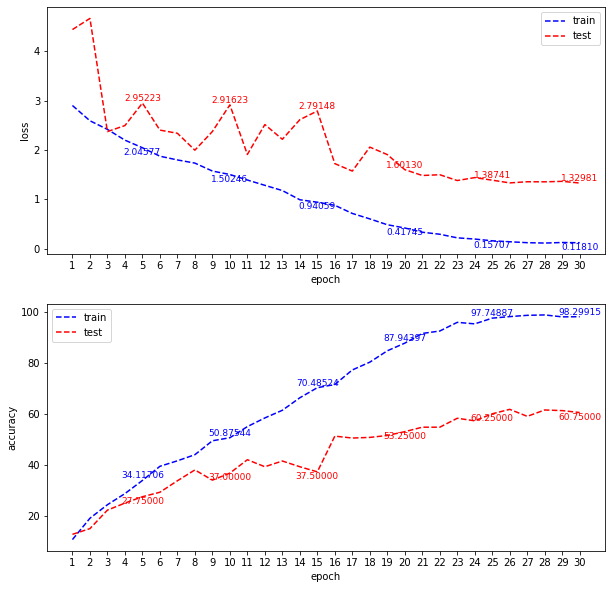

In [ ]:
#visualize metric
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = [i for i in range(1, epochs+1)]

ax1.plot(x, train_loss_list, 'b--')
ax1.plot(x, test_loss_list, 'r--')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'])
ax1.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, train_loss_list[i], "{:0.5f}".format(train_loss_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='top')
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, test_loss_list[i], "{:0.5f}".format(test_loss_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='bottom')


ax2.plot(x, train_acc_list, 'b--')
ax2.plot(x, test_acc_list, 'r--')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'])
ax2.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, train_acc_list[i], "{:0.5f}".format(train_acc_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='bottom')
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, test_acc_list[i], "{:0.5f}".format(test_acc_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='top')

plt.show()